In [11]:
# Basic libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Similarity search
from sklearn.metrics.pairwise import cosine_similarity

# Progress bar (optional)
try:
    from tqdm import tqdm
except:
    print("tqdm not installed, progress bar will not be shown")
    tqdm = lambda x, **kwargs: x


In [12]:
DATASET_PATH = "dataset"
OUTPUT_PATH = "outputs"
os.makedirs(OUTPUT_PATH, exist_ok=True)


In [13]:
image_paths = []
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, file))

print(f"Total images found: {len(image_paths)}")
print("First 5 images:", image_paths[:5])


Total images found: 2745
First 5 images: ['dataset\\seg_test\\seg_test\\forest\\20056.jpg', 'dataset\\seg_test\\seg_test\\forest\\20062.jpg', 'dataset\\seg_test\\seg_test\\forest\\20082.jpg', 'dataset\\seg_test\\seg_test\\forest\\20089.jpg', 'dataset\\seg_test\\seg_test\\forest\\20091.jpg']


In [14]:
model = ResNet50(weights="imagenet", include_top=False, pooling='avg')


In [15]:
def batch_embeddings(image_paths, model, batch_size=32):
    embeddings = []
    valid_paths = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        
        for path in batch_paths:
            try:
                img = image.load_img(path, target_size=(224,224))
                img_array = image.img_to_array(img)
                batch_images.append(img_array)
            except Exception as e:
                print(f"Skipping {path}: {e}")
        
        if len(batch_images) == 0:
            continue
        
        batch_images = np.array(batch_images)
        batch_images = preprocess_input(batch_images)
        batch_emb = model.predict(batch_images, verbose=0)
        
        embeddings.extend(batch_emb)
        valid_paths.extend(batch_paths)
    
    embeddings = np.array(embeddings)
    return embeddings, valid_paths


In [16]:
embeddings, valid_paths = batch_embeddings(image_paths, model, batch_size=32)

print("Embeddings shape:", embeddings.shape)
print("Valid images:", len(valid_paths))

np.save(os.path.join(OUTPUT_PATH, "embeddings.npy"), embeddings)
np.save(os.path.join(OUTPUT_PATH, "image_paths.npy"), valid_paths)
print("✅ Embeddings and paths saved!")


Embeddings shape: (2745, 2048)
Valid images: 2745
✅ Embeddings and paths saved!


In [17]:
embeddings = np.load(os.path.join(OUTPUT_PATH, "embeddings.npy"))
image_paths = np.load(os.path.join(OUTPUT_PATH, "image_paths.npy"), allow_pickle=True)

print("✅ Embeddings and paths loaded")
print("Total images:", len(image_paths))


✅ Embeddings and paths loaded
Total images: 2745


In [18]:
def find_similar_images(query_img_path, embeddings, image_paths, model, top_k=5):
    try:
        img = image.load_img(query_img_path, target_size=(224,224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        query_embedding = model.predict(img_array, verbose=0).flatten()
    except Exception as e:
        print(f"Cannot process {query_img_path}: {e}")
        return []
    
    similarities = cosine_similarity(query_embedding.reshape(1, -1), embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [(image_paths[i], similarities[i]) for i in top_indices]


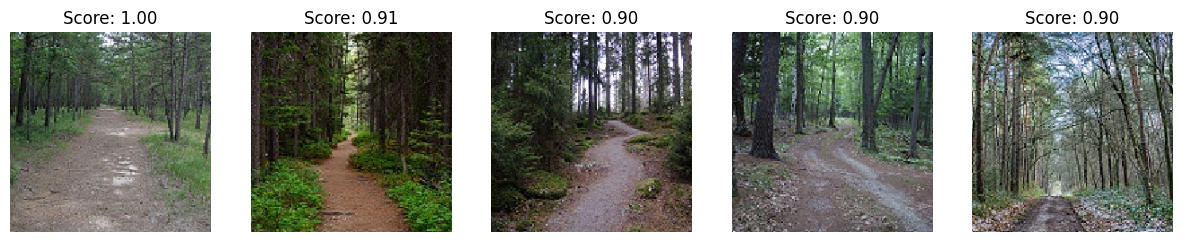

In [20]:
query_image = image_paths[0]  # Pick first image as query
results = find_similar_images(query_image, embeddings, image_paths, model, top_k=5)

plt.figure(figsize=(15,5))
for i, (img_path, score) in enumerate(results):
    img = image.load_img(img_path, target_size=(224,224))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Score: {score:.2f}")
    plt.axis('off')
plt.show()


In [21]:
import os

query_image = r"C:\Users\shejo\OneDrive\Desktop\query_images\download (1).jpg"
print(os.path.exists(query_image))  # Should print True


True


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_images(query_img_path, embeddings, image_paths, model, top_k=5):
    query_embedding = get_embedding(query_img_path, model)

    if query_embedding is None:
        raise ValueError("Query image could not be processed")

    query_embedding = query_embedding.reshape(1, -1)

    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]

    results = [(image_paths[i], similarities[i]) for i in top_indices]
    return results


In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

def get_embedding(img_path, model):
    try:
        img = image.load_img(img_path, target_size=(224,224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        embedding = model.predict(img, verbose=0)
        return embedding.flatten()
    except Exception as e:
        print(f"Cannot process {img_path}: {e}")
        return None


In [24]:
results = find_similar_images(query_image, embeddings, image_paths, model, top_k=5)


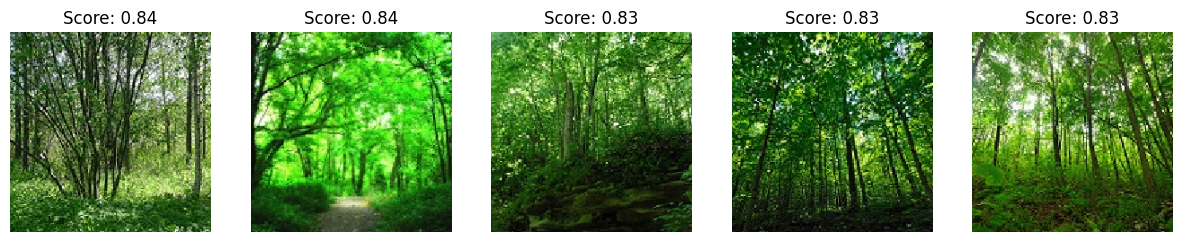

In [25]:
results = find_similar_images(query_image, embeddings, image_paths, model, top_k=5)

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(15,5))
for i, (img_path, score) in enumerate(results):
    img = image.load_img(img_path, target_size=(224,224))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"Score: {score:.2f}")
    plt.axis('off')
plt.show()
